# Tutorial: BAX to improve Accuracy of Interpretability Measures 

In [17]:
from argparse import Namespace

import torch
import numpy as np 
import matplotlib.pyplot as plt 
import copy

from botorch.test_functions.synthetic import StyblinskiTang
from botorch.acquisition.algorithm import PDPAlgorithm
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from gpytorch import ExactMarginalLogLikelihood

## Test function 

We have a look at the d-dimensional Styblinski-Tang function 

$$ \frac{1}{2} \sum_{i = 1}^d (x_i^4 - 16 x_i^2 + 5 x_i), x_i \in [-5, 5]. $$

Here $d = 2$ for visualization purposes. 

In [3]:
d = 2
f = StyblinskiTang(dim=d)

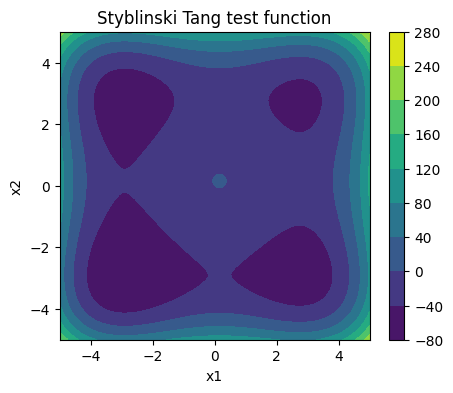

In [5]:
# PLOT

x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)
Y = f(X).reshape(100, 100).numpy()

plt.figure(figsize=(5, 4))
plt.contourf(X1.numpy(), X2.numpy(), Y, levels=8)
plt.colorbar()
plt.title('Styblinski Tang test function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We are interested in visualizing the partial dependence of the *true* function $f$, which is 

$$
    f_1\left(x_1\right) = \int_{X_2} f(x_1, x_2) ~\mathrm{d}\mathbb{P}(x_2)
$$



**Note**: Practically, we would deal with functions of dimensions higher than $2$, which are challenging to visualize directly. Computing the partial dependence allows us to gain insights into multidimensional functions, making them more interpretable in a visual format.

In [27]:
params = {"name": "PDP", "xs": 1, "n_points": 50, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

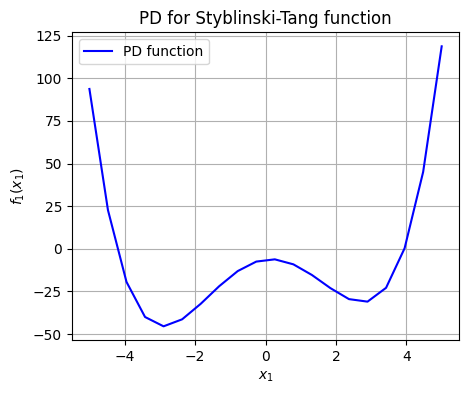

In [30]:
# PLOT 

plt.figure(figsize=(5, 4))

x = out[1].x
y = out[1].y
sd = out[1].var.mean()

# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')

# Plot uncertainty bands
# plt.fill_between(x, y - std_dev, y + std_dev, color='blue', alpha=0.2, label='Uncertainty')

# Optional configurations
plt.title(r'PD for Styblinski-Tang function')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$f_1(x_1)$')
plt.legend()
plt.grid(True)

## Black-box test functions

In real-world dettings, we deal with functions without knowing their analytical formula. In addition, they are often expensive to evaluate. We may only have a set of sample points, represented as archive $A_T = \{(x^{(i)}, y^{(i)})\}_{i = 1, ..., T}$, where each $x^{(i)}$ is associated with a function value $y^{(i)} = f(x^{(i)})$.

We can fit a model $\hat f$ as approximation to the true but unknown $f$, for example a Gaussian process. $\hat f$ allows us to make predictions and further analyses. 

We simulate this scenario. 

In [31]:
sobol = SobolEngine(dimension=d, scramble=True, seed=None)

data = Namespace()
X = sobol.draw(n=20)
data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
data.y = f(data.x).unsqueeze(0).T

data.x = data.x.to(dtype=torch.float)
data.y = data.y.to(dtype=torch.float)

model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

print("Lengthscale:", model.covar_module.base_kernel.lengthscale)
print("Outputscale:", model.covar_module.outputscale)
print("Noise:", model.likelihood.noise)


/home/julia/Documents/repos/botorch/botorch/models/gp_regression.py:120: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)


Lengthscale: tensor([[0.2318, 0.4722]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(1.9559, grad_fn=<SoftplusBackward0>)
Noise: Parameter containing:
tensor([0.1549], requires_grad=True)


Instead of visualizing the PD of $f$, we visualize the PD of $\hat f$. 

In [34]:
from botorch.acquisition.bax import InfoBAX

params = {"name": "BAX", "n_path": 10, "exe_path_dependencies": False}
EIG = InfoBAX(params=params, model=model, algorithm=alg)

out_approx = EIG.output_list[0]

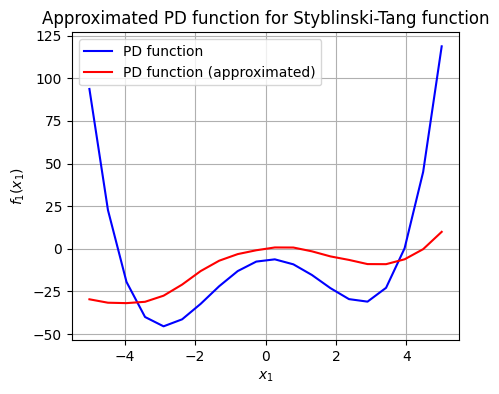

In [35]:
# PLOT 

plt.figure(figsize=(5, 4))

x_approx = out_approx.x.tolist()
y_approx = out_approx.y.tolist()

# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(x_approx, y_approx, label='PD function (approximated)', color='red')

# Optional configurations
plt.title(r'Approximated PD function for Styblinski-Tang function')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$f_1(x_1)$')
plt.legend()
plt.grid(True)

**Key question**: What are the best samples $(x_{(i)}, y_{(i)})$ to approximated the PD function best? 

## Expected information gain

We would like to compute the expected information gain (EIG) of a point $\bm{\tilde x}$ on the algorithm output $\mathcal{O}_\mathcal{A}$ (i.e., the PDP). 

The formula for this is: 

$$
    \textrm{EIG}^e_T(\mathbf{x}) = \underbrace{\mathbb{H}\left[f_{\mathbf{x}}|A_T\right]}_{(1)} - \underbrace{\mathbb{E}_{e_{\mathcal{A}}|A_T}\left[\mathbb{H}\left[f_{\mathbf{x}}|A_T, e_\mathcal{A}\right]\right]}_{(1)}
$$


Here, $e_\mathcal{A}$ is the execution path, i.e., the sequence of all evaluations the PDP algorithm $\mathcal{A}$ traverses, which gives full information about the output $\mathcal{O}_\mathcal{A}$ of the PDP algorithm. 



Let's say we want to compute the information gain of a randomly drawn point $\bm{\tilde x}$. 


#### Expected information gain: Part (1)

Let's take it step by and look at part (1) of this formula. That is pretty easy to compute as this is just the entropy of our posterior predictive distribution at an input $\bm{\tilde x}$ and it can be computed in [closed form](https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/): 

$$
    \mathbb{H}\left[f_{\mathbf{x}}|A_T\right] = \frac{1}{2}\log(2 \pi \sigma^2) + \frac{1}{2}
$$

with $f_x \sim \mathcal{N}\left(\mu, \sigma^2\right)$ with $\mu = m_\textrm{post}(\bm{\tilde x}), \sigma^2 = k_\textrm{post}(\bm{\tilde x}, \bm{\tilde x})$. 

In [36]:
X = torch.rand(1, d, device="cpu", dtype=torch.float)

posterior = model.posterior(
    X.unsqueeze(-3), observation_noise=False, posterior_transform=None
)

mu = posterior.mean
sigma2 = posterior.variance.detach().numpy().flatten()

In [37]:
h_post = 0.5 * np.log(2 * np.pi * sigma2) + 0.5
h_post

array([4.5715246], dtype=float32)

#### Expected information gain: Part (2)

The second part is trickier to compute 

$$
    \mathbb{E}_{e_{\mathcal{A}}|A_T}\left[\mathbb{H}\left[f_{\mathbf{x}}|A_T, e_\mathcal{A}\right]\right]
$$

* We cannot compute the expected value analytically; instead, we sample $n_{\textrm{path}}$ samples of the execution path $e_A$, and approximate the expression via a mean estimator.  

* We do not have $f_{\mathbf{x}}|A_T, e_A$ readily available; we need to fit the posterior process $f_{\mathbf{x}}|A_T, e_A$ before computing the entropy. 

In our case, let's say $n_\textrm{path} = 3$ (typically we would set this higher). The acquisition function samples $n_\textrm{path}$ execution path samples (which correspond to realizations of a PDP).  

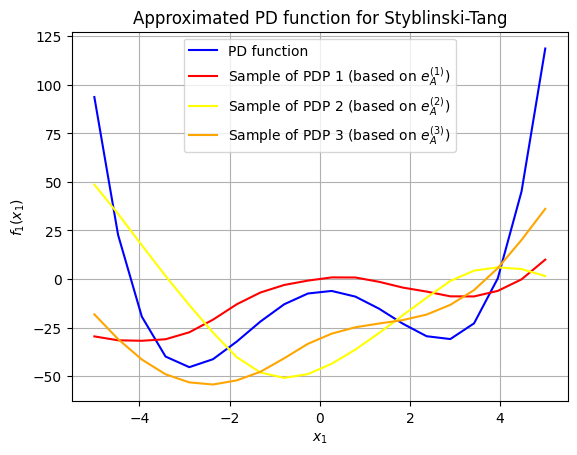

In [38]:
# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(EIG.output_list[0].x.tolist(), EIG.output_list[0].y.tolist(), label=r'Sample of PDP 1 (based on $e_A^{(1)}$)', color='red')
plt.plot(EIG.output_list[1].x.tolist(), EIG.output_list[1].y.tolist(), label=r'Sample of PDP 2 (based on $e_A^{(2)}$)', color='yellow')
plt.plot(EIG.output_list[2].x.tolist(), EIG.output_list[2].y.tolist(), label=r'Sample of PDP 3 (based on $e_A^{(3)}$)', color='orange')

# Optional configurations
plt.title('Approximated PD function for Styblinski-Tang')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$f_1(x_1)$')
plt.legend()
plt.grid(True)

Now, we do re-fits of the model and compute the posterior $f_x ~|~ A_T, e_A$. For each of the execution path samples we can compute the posterior. 

For illustration purposes, we do that manually (while in reality, the acquisition function performs this internally) for one of the execution paths. 

In [39]:
exe_path = EIG.exe_path_full_list

In [42]:
exe_path = EIG.exe_path_full_list[0]

exe_path_new = Namespace()

# 1. Condition the model on eA  
exe_path_new.x = torch.stack(exe_path.x).to(dtype=torch.float)
exe_path_new.y = torch.stack(exe_path.y).to(dtype=torch.float).detach()

model_cond = copy.deepcopy(EIG.model)
post = model_cond.posterior(X)
X_new = exe_path_new.x
Y_new = exe_path_new.y.view(-1, 1)

# f | ()
model_cond = model_cond.condition_on_observations(X=X_new, Y=Y_new)

/home/julia/Documents/repos/botorch/botorch/models/gpytorch.py:466: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=X, Y=Y, Yvar=noise, strict=False)
/home/julia/Documents/repos/botorch/botorch/models/gpytorch.py:232: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=X, Y=Y, Yvar=Yvar, strict=False)


In [43]:
# Now compute the entropy based on this model
posterior_samp = model_cond.posterior(X)     

# # 2. Computer posterior y_x | (D, eA)
# posterior_samp = model_new.posterior(X)
std_samp = posterior_samp.variance.detach().numpy().flatten()

# 3. Formula for entropy 
h_samp = np.log(std_samp) + np.log(np.sqrt(2 * np.pi)) + 0.5

h_samp

array([7.590949], dtype=float32)

#### Computation of the acquisition function

Now that we got the acquisition function together, we can compute it's value for a candidate $\mathbf{\tilde x}$. 

In [44]:
EIG.forward(X)

array([0.13316202], dtype=float32)

Now let's compute it for a bunch of candidate points and let's see what is the best one to pick! 

In [45]:
candidate_set = torch.rand(50, d, device="cpu")
candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set
candidate_set = candidate_set.to(dtype=torch.float)

In [46]:
acq_values = EIG.forward(candidate_set)
acq_values 

array([0.06107759, 0.850791  , 0.426023  , 0.5729265 , 0.02834082,
       0.369936  , 0.10535002, 0.663548  , 0.25996828, 0.08900547,
       0.13197136, 0.13616037, 0.2792349 , 0.04911375, 0.48806572,
       0.11324453, 0.68360233, 0.39222813, 0.24664783, 0.09989691,
       0.12328577, 0.13559818, 0.01436663, 0.1539278 , 0.963604  ,
       0.02414894, 0.43371725, 0.73988104, 0.11584854, 0.07918644,
       0.03731823, 0.02053785, 0.2738428 , 0.3343463 , 0.19377232,
       0.19875622, 0.0425849 , 0.71356964, 0.37378168, 0.4654894 ,
       0.7977648 , 0.40521002, 0.272336  , 0.17480087, 0.35022783,
       0.20799494, 0.00854874, 0.6986227 , 0.31509972, 0.2625394 ],
      dtype=float32)

In [47]:
# PLOT
x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

model.eval()
with torch.no_grad():
    post = model.posterior(X)
    mean = post.mean.cpu().numpy()
    variance = post.variance.cpu().numpy()
    std_dev = torch.sqrt(post.variance).cpu().numpy()

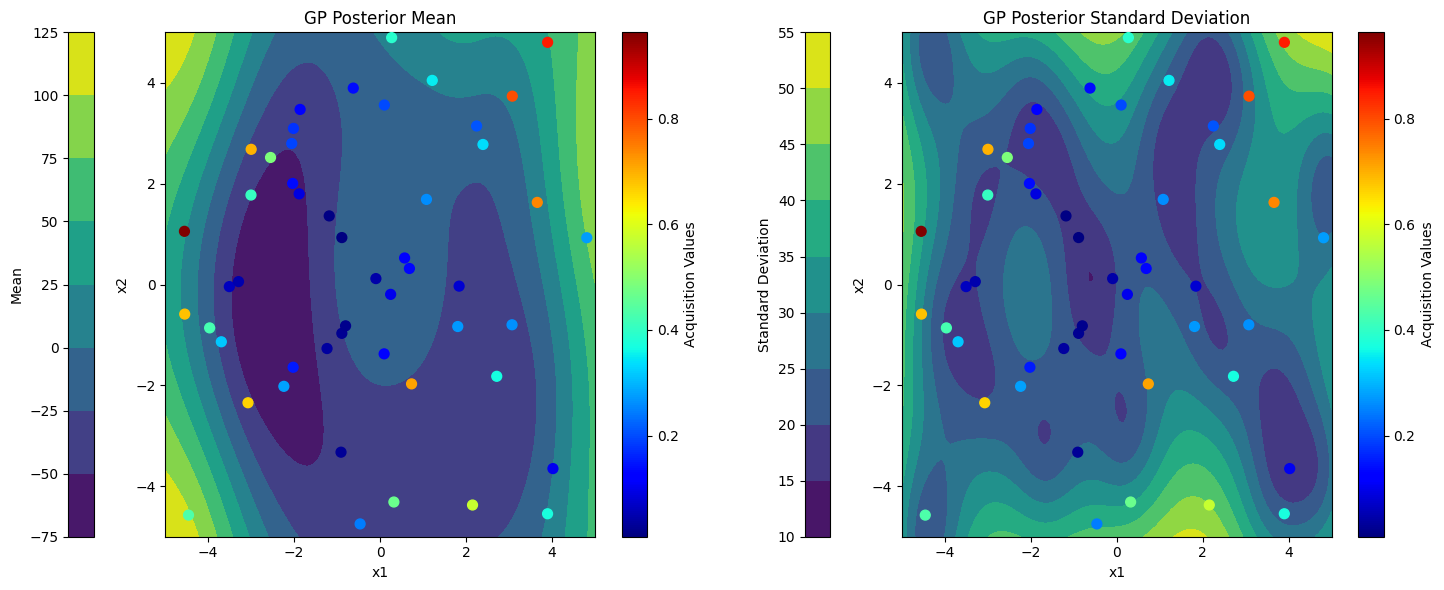

In [48]:
# PLOT 

fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean on the left subplot
contour_mean = axarr[0].contourf(X1.numpy(), X2.numpy(), mean.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[0], location='left')
cbar_mean.ax.set_ylabel('Mean')
axarr[0].set_title("GP Posterior Mean")
axarr[0].set_xlabel("x1")
axarr[0].set_ylabel("x2")

# Overlay training data on the mean plot
scatter_points = axarr[0].scatter(candidate_set[:, 0].numpy(), candidate_set[:, 1].numpy(), c=acq_values, cmap='jet', s=50, zorder=10, label='Training Data')
cbar_points_mean = fig.colorbar(scatter_points, ax=axarr[0], location='right')
cbar_points_mean.ax.set_ylabel('Acquisition Values')

# Plot standard deviation on the right subplot
contour_std = axarr[1].contourf(X1.numpy(), X2.numpy(), std_dev.reshape(100, 100))
cbar_std = fig.colorbar(contour_std, ax=axarr[1], location='left')
cbar_std.ax.set_ylabel('Standard Deviation')
axarr[1].set_title("GP Posterior Standard Deviation")
axarr[1].set_xlabel("x1")
axarr[1].set_ylabel("x2")

# Overlay training data on the standard deviation plot
scatter_points_std = axarr[1].scatter(candidate_set[:, 0].numpy(), candidate_set[:, 1].numpy(), c=acq_values, cmap='jet', s=50, zorder=10, label='Training Data')
cbar_points_std = fig.colorbar(scatter_points_std, ax=axarr[1], location='right')
cbar_points_std.ax.set_ylabel('Acquisition Values')

plt.tight_layout()
plt.show()


## Running BAX for PDP 


In [76]:
# Initial design 
sobol = SobolEngine(dimension=d, scramble=True, seed=None)
X = sobol.draw(n=20)
X = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
Y = f(X).unsqueeze(0).T

data = Namespace(x = X.to(dtype=torch.float), y = Y.to(dtype=torch.float))

num_iterations = 30

# Optimization loop 
for iteration in range(num_iterations):
    model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);

    params = {"name": "PDP", "xs": 1, "n_points": 50, "bounds": f.bounds, "grid_size": 20}
    alg = PDPAlgorithm(params)
    alg.initialize()

    params = {"name": "BAX", "n_path": 20, "exe_path_dependencies": False}
    EIG = InfoBAX(params=params, model=model, algorithm=alg)

    candidate_set = torch.rand(1000, d, device="cpu")
    candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set
    candidate_set = candidate_set.to(dtype=torch.float)

    acq_values = EIG.forward(candidate_set)

    idx_best = np.argmax(acq_values)  
    candidate_new = candidate_set[idx_best, ].unsqueeze(0)

    data.x = torch.cat((data.x, candidate_set[idx_best, ].unsqueeze(0)), dim=0)   
    data.y = torch.cat((data.y, f(candidate_new).unsqueeze(0)), dim=0)

/home/julia/Documents/repos/botorch/botorch/models/gp_regression.py:120: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)
/home/julia/miniconda3/envs/botorch-new/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/julia/miniconda3/envs/botorch-new/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/julia/miniconda3/envs/botorch-new/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/julia/miniconda3/envs/boto